In [248]:
#%load_ext lab_black
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
from statsmodels.sandbox.regression import gmm
import matplotlib.pyplot as plt
import seaborn as sns

#Linear City Model

In [249]:
def drawConsumer (L:int=1):
    """L: number of goods"""
    c = {
        "id": np.random.randint(10**9,2*10**9), 
        "type": "consumer",
        "wealth": np.random.rand(),
        "talent": np.random.rand(),
        "taste": np.random.rand(L),
        "mc_transport": 0.05,
        'supplier': None,
        'lot': None
    }
    return(c)

In [250]:
def drawFirm (L:int=1):
    f = {
        "id": np.random.randint(10**9,2*10**9), 
        "type": "firm",
        "mc": np.random.rand()/4,
        "good": np.random.randint(0,L),
        'lot': None,
    }
    return(f)

In [251]:
def floorCost (lvl: int):
    """returns cost for moving into floor lvl x"""
    cost = lvl ** 2 / 4
    return(cost)

In [252]:
def settleConsumer (city:list, consumer:dict=drawConsumer()):
    # give a value to each possible settlement position
    supplier = consumer["supplier"]
    choiceValues = list(map(lambda x: -floorCost(len(x)), city))
    for choiceInd, choice in enumerate(city):
        for lotInd, lot in enumerate(city):
            for party in lot:
                if(party['type'] == 'firm'):
                    partyValue = consumer['taste'][party["good"]] - party["mc"] - abs(lotInd-choiceInd) * consumer['mc_transport']
                else:
                    partyValue = 0  
                if(choiceValues[choiceInd] <= (partyValue - floorCost(len(choice)))):
                    choiceValues[choiceInd] = partyValue - floorCost(len(choice))
                    supplier = party['id']
    
    if(max(choiceValues)<0):
        print('consumer wont settle')
    else: 
        # find all choice options with best value
        maxValues = [x == max(choiceValues) for x in choiceValues]
        # randomly choose one of them and return index
        choiceInd = [c for (c, m) in zip(range(len(city)), maxValues) if m][np.random.randint(0,sum(maxValues))]
        print(choiceInd)
        # possible remove consumer from old lot
        if(consumer['lot'] != choiceInd):
            if(consumer['lot'] != None):
                # remove consumer from old location
                if(consumer in city[consumer['lot']]):
                    city[consumer['lot']].remove(consumer)
            # add to new location
            consumer['lot'] = choiceInd
            consumer["supplier"] = supplier
            city[choiceInd].append(consumer)

    # return(city)

In [253]:
list(map(lambda x: len(list(filter(lambda y: y["type"]=="firm",x))),city))

[0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

0
4
1
18
2
7
3
14
4
12
5
5
6
consumer wont settle
7
6
8
4
9
7
10
consumer wont settle
11
13
12
consumer wont settle
13
9
14
8
15
consumer wont settle
16
12
17
consumer wont settle
18
consumer wont settle
19
consumer wont settle
20
14
21
15
22
consumer wont settle
23
consumer wont settle
24
consumer wont settle
25
consumer wont settle
26
consumer wont settle
27
consumer wont settle
28
consumer wont settle
29
consumer wont settle
30
consumer wont settle
31
consumer wont settle
32
consumer wont settle
33
consumer wont settle
34
consumer wont settle
35
consumer wont settle
36
consumer wont settle
37
consumer wont settle
38
consumer wont settle
39
consumer wont settle
40
consumer wont settle
41
consumer wont settle
42
consumer wont settle
43
consumer wont settle
44
consumer wont settle
45
consumer wont settle
46
consumer wont settle
47
consumer wont settle
48
consumer wont settle
49
consumer wont settle


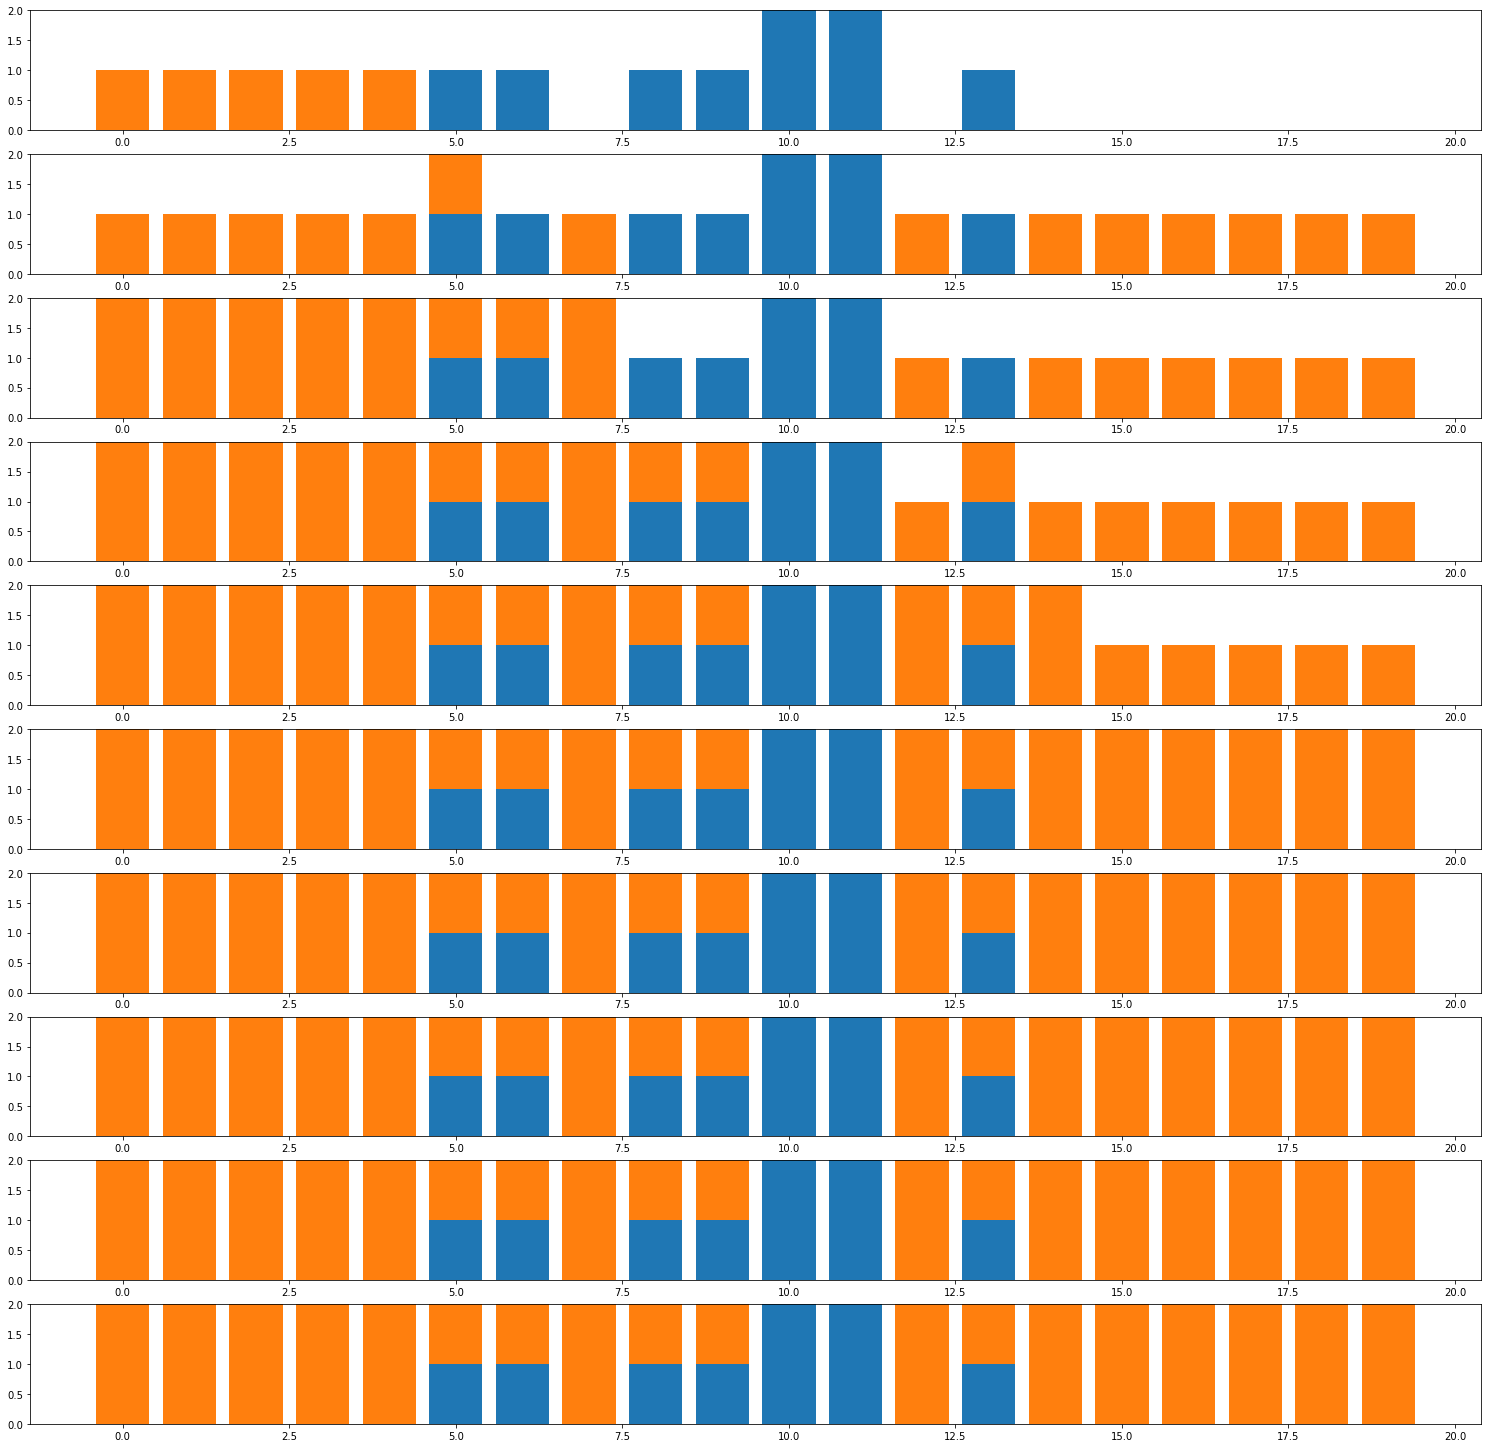

In [257]:
#city = np.array([[]*np.random.randint(0,2)]*10)
city = [[]] * 5 + list(map(lambda x: [drawFirm()]*np.random.randint(0,3), [1]*10)) +[[]] * 5

fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(26,26))
for i in range(50):
    settleConsumer(city, drawConsumer())
    if(i%5 == 0):
        
        labels = range(len(city))
        n_firms = list(map(lambda l: len(list(filter(lambda p: p["type"]=="firm", l))),city))
        n_consumers = list(map(lambda l: len(list(filter(lambda p: p["type"]=="consumer", l))),city))
        #width = 0.35       # the width of the bars: can also be len(x) sequence
        ax.flat[i // 5].bar(labels, n_firms, label='firms')
        ax.flat[i // 5].bar(labels, n_consumers, bottom=n_firms, label='consumer')

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.legend()

plt.show()


In [255]:
7 // 5

1

In [256]:
consumer

NameError: name 'consumer' is not defined

In [ ]:
city

[[],
 [],
 [],
 [],
 [],
 [{'id': 1609051454,
   'type': 'firm',
   'mc': 0.10750656589292473,
   'good': 0,
   'lot': None},
  {'id': 1609051454,
   'type': 'firm',
   'mc': 0.10750656589292473,
   'good': 0,
   'lot': None}],
 [{'id': 1238715298,
   'type': 'firm',
   'mc': 0.20478454582520722,
   'good': 0,
   'lot': None},
  {'id': 1238715298,
   'type': 'firm',
   'mc': 0.20478454582520722,
   'good': 0,
   'lot': None}],
 [{'id': 1655733875,
   'type': 'firm',
   'mc': 0.080533644741097,
   'good': 0,
   'lot': None}],
 [{'id': 1233447113,
   'type': 'firm',
   'mc': 0.19796616358418817,
   'good': 0,
   'lot': None}],
 [{'id': 1614250782,
   'type': 'firm',
   'mc': 0.12741496209824446,
   'good': 0,
   'lot': None},
  {'id': 1614250782,
   'type': 'firm',
   'mc': 0.12741496209824446,
   'good': 0,
   'lot': None}],
 [{'id': 1907283821,
   'type': 'firm',
   'mc': 0.2332003065304248,
   'good': 0,
   'lot': None},
  {'id': 1907283821,
   'type': 'firm',
   'mc': 0.2332003065304

In [ ]:
settleConsumer(city)[settleConsumer(city)==max(settleConsumer(city))]

-0.4

In [ ]:
list(map(lambda x: -floorCost(len(x)), city))

[-0.4, -0.0, -0.0, -0.4, -0.4, -0.4, -0.0, -0.0, -0.1, -0.0]

In [ ]:
def settleFirm ():
    return()

In [ ]:
floorCost(10)

10.0

In [ ]:
# number of goods
L = 1
# number of lots in linear city
H = 10
# maximum floor number
maxFloor = float('inf')